In [1]:
import sys
import numpy as np
import os
from image_utils import standardize
from IOU_computations import *
from numpy import newaxis
import matplotlib.pyplot as plt
from dataset_generator_2 import Dataset_sat


import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
from resunet_main_fin import predict,criterion
import torch.backends.cudnn as cudnn

/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:

INPUT_CHANNELS=9
NB_CLASSES=2
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DEFAULT_WIDTH_KERNEL=3
BINS=15

DEFAULT_HIDDEN_FEATURES=[32,64,128,256]
DEFAULT_N_RESBLOCKS=1
N_DILATED_CONV=3
DEFAULT_GATED=False
DEFAULT_GROUP_NORM=0
DEFAULT_PADDING=1


In [8]:
def plot_summary(predictions,labels,pansharp,batch_size,batch_number,prediction_path,display='all'):
    
    if display=='all':
        fig,axs=plt.subplots(3, batch_size,figsize=(8*batch_size,24))

        axs[0,0].set_title(str(batch_number)+' Pansharpened ', fontsize='large')
        axs[1,0].set_title(str(batch_number)+' Groundtruth ', fontsize='large')
        axs[2,0].set_title(str(batch_number)+' Predictions ', fontsize='large')


        for i in range(batch_size):

            axs[0,i].imshow(pansharp[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Pansharpened_'+str(i)+'.jpg',pansharp[i])
            axs[1,i].imshow(labels[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Groundtruth_'+str(i)+'.jpg',labels[i])
            axs[2,i].imshow(predictions[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Predictions_'+str(i)+'.jpg',predictions[i])
    
    else:
        fig,axs=plt.subplots(1, batch_size,figsize=(8*batch_size,24))
        axs[0].set_title(str(batch_number)+' Predictions ', fontsize='large')
        for i in range(batch_size):
            axs[i].imshow(predictions[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Predictions_'+str(i)+'.jpg',predictions[i])
        

    plt.show()



In [9]:
def generate_dataset(path_validation,validation_batch_size):
    val_generator=Dataset_sat.from_root_folder(path_validation,NB_CLASSES)
    val_loader = DataLoader(val_generator, batch_size=validation_batch_size,shuffle=False, num_workers=1)
    
    return val_loader

In [10]:
def predict_pytorch_val(val_loader,number_iterations,restore_path,prediction_path,display,param=None,unet_v=2):
    TMP_IOU=prediction_path+'TMP_IOU/'
    if not os.path.exists(TMP_IOU):
            os.makedirs(TMP_IOU)
    loss_fn=nn.CrossEntropyLoss()
    
    if unet_v==2:
        model=UNet(INPUT_CHANNELS,NB_CLASSES,depth=DEFAULT_LAYERS,n_features_zero=DEFAULT_FEATURES_ROOT,dropout=0,width_kernel=DEFAULT_WIDTH_KERNEL,distance_net=param,bins=BINS,batch_norm=True)
    elif unet_v==3:
        model=UNet(INPUT_CHANNELS,NB_CLASSES,num_hidden_features =DEFAULT_HIDDEN_FEATURES,n_resblocks=DEFAULT_N_RESBLOCKS,num_dilated_convs=N_DILATED_CONV,dropout=0,gated=DEFAULT_GATED,kernel_size=DEFAULT_WIDTH_KERNEL,padding=DEFAULT_PADDING, group_norm=DEFAULT_GROUP_NORM)
        
    model.cuda()
    cudnn.benchmark = True
    model.load_state_dict(torch.load(restore_path))
    

    counter=0
    for i_batch,sample_batch in enumerate(val_loader):
        X_val=standardize(sample_batch['input'])
        Y_val=sample_batch['groundtruth']

        predictions=[]
        for j in range(len(X_val)):
            X_val_j=X_val[j]
            X_val_j=X_val_j[newaxis,:,:,:]
            X_val_j=standardize(X_val_j)
            Y_val_j=Y_val[j]
            Y_val_j=Y_val_j[newaxis,:,:,:]
            
            X = Variable(X_val_j.float())
            X=X.permute(0,3,1,2).cuda()  
            Y = Variable(Y_val_j.float())
            Y=Y.cuda()  
            if param:
                _,predictions_i=predict(model,X,param)
            else:
                predictions_i=predict(model,X)
            loss_i=criterion(Y,predictions_i)
            loss_i=loss_i.data[0]
            predictions_i=predictions_i.data.cpu().numpy()
            Y_val_j=np.asarray(Y_val_j)
            iou_acc_v,f1_v,iou_v=predict_score_batch(TMP_IOU,np.argmax(Y_val_j,3),np.argmax(predictions_i,3))
#             print("Image {:d}, Validation IoU {:.4f}, Validation IoU_acc {:.4f}%,Validation F1 IoU {:.4f}%, loss {:.8f}".format(j,iou_v,iou_acc_v,f1_v,loss_i))
            predictions.append(predictions_i)
            
        predictions=np.squeeze(np.asarray(predictions))
        X_val=np.asarray(X_val)
        Y_val=np.asarray(Y_val)
        if X_val.shape[-1]==9:
            pansharp=np.stack((X_val[:,:,:,5],X_val[:,:,:,3],X_val[:,:,:,2]),axis=3)
        elif X_val.shape[-1]==5 or X_val.shape[-1]==17:
            pansharp=np.stack((X_val[:,:,:,3],X_val[:,:,:,2],X_val[:,:,:,1]),axis=3)
                
        plot_summary(np.argmax(predictions,3),np.argmax(Y_val,3),pansharp,len(X_val),counter,prediction_path,display)
        counter+=1
        if counter==number_iterations:
            break
            
        
        

SPACENET UNET DILATED 2


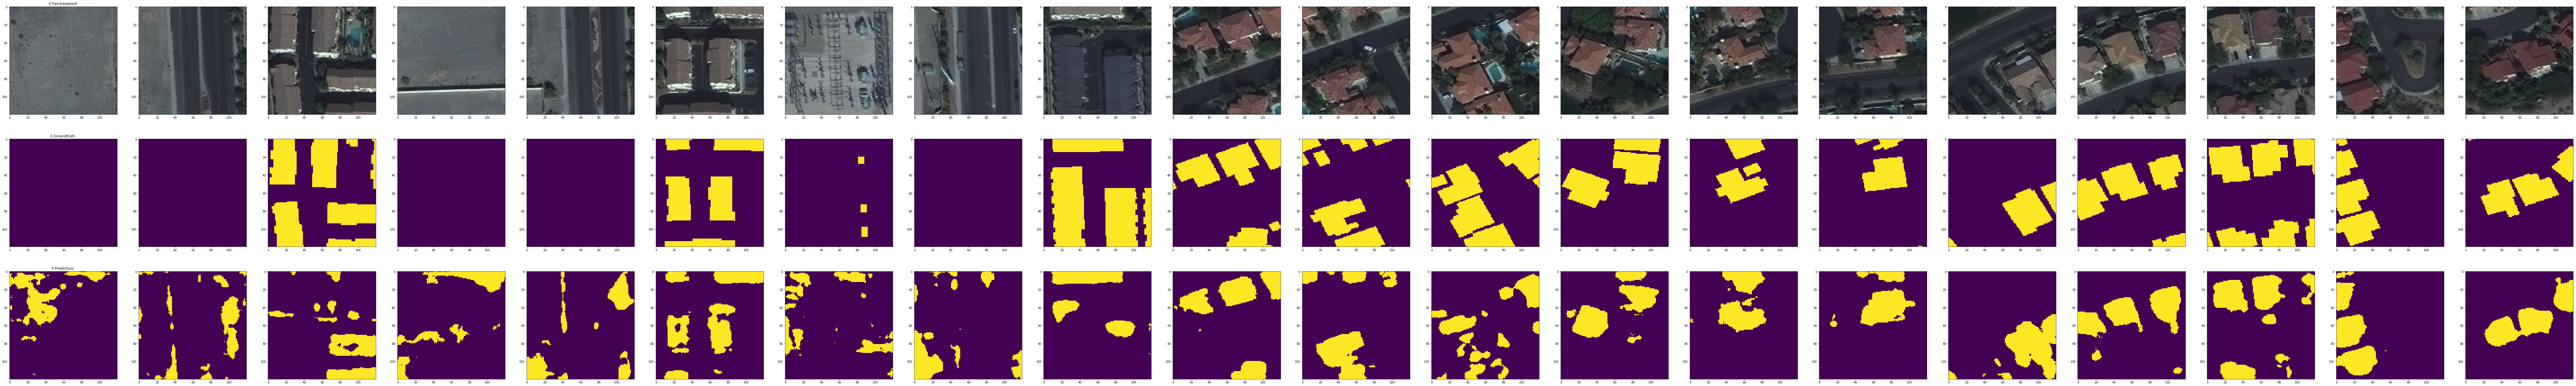

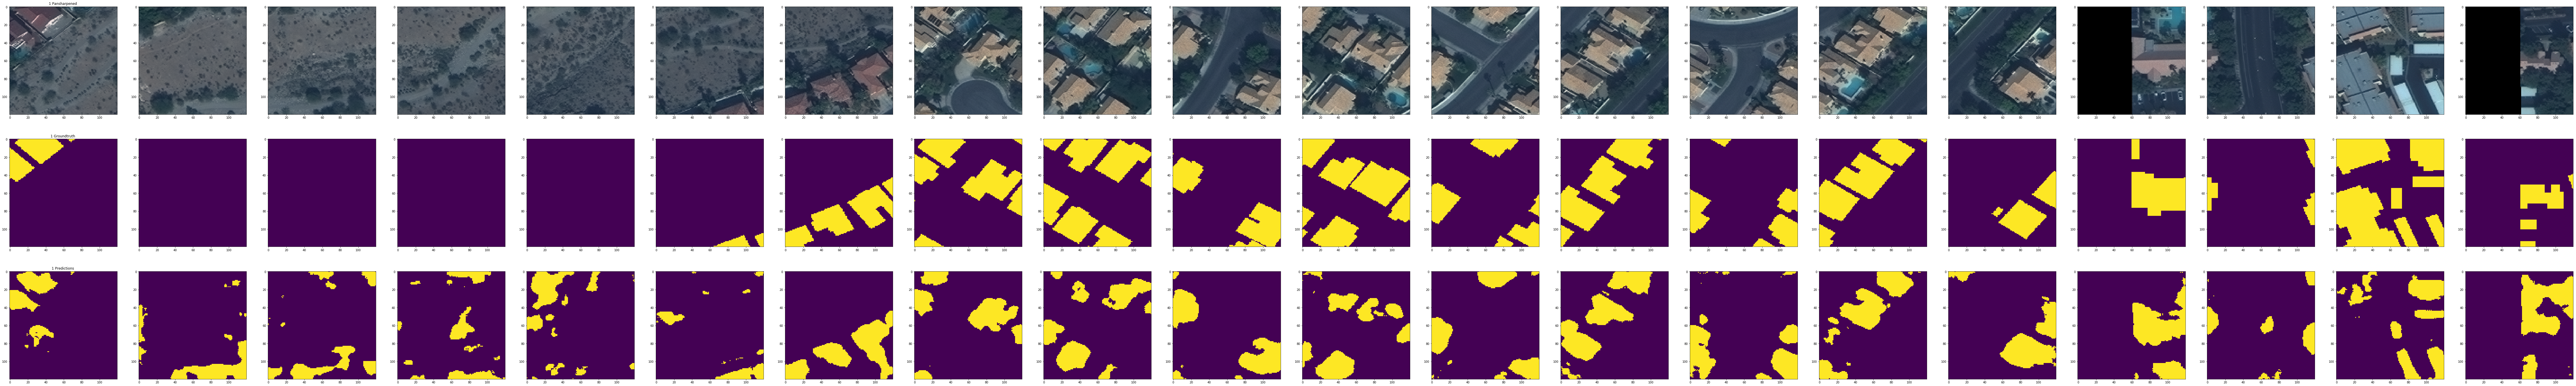

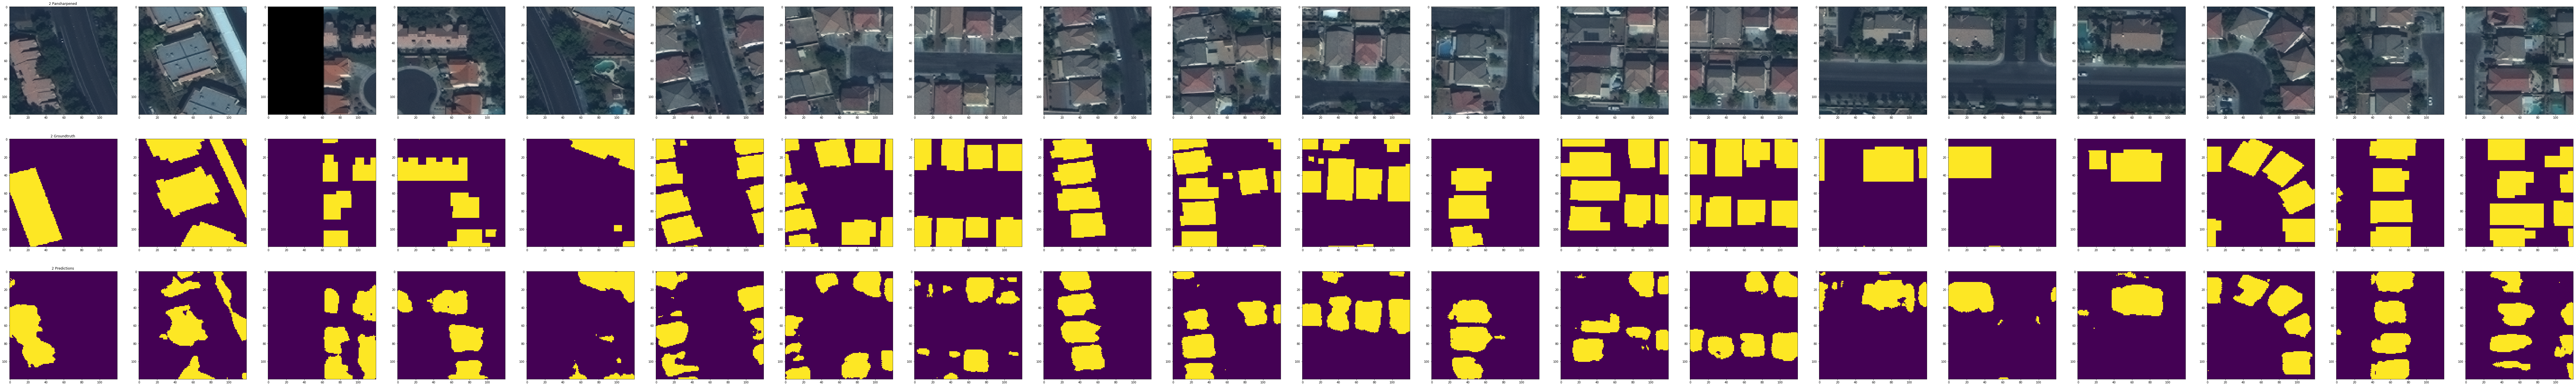

In [11]:
if __name__ == '__main__':
    
     ####GHANA #######
    
    root_folder = '../2_DATA_GHANA/DATASET/120_x_120_8_pansh/'
#     root_folder ='/scratch/SPACENET_DATA_PROCESSED/DATASET/120_x_120_8_bands_pansh/'
    
    validation_loader=generate_dataset(root_folder+'TEST/',20)
    
    
    
    
    
#      ####VAL GHANA########
    
#     from unet_val import UNet

#     prediction_path='VISUALIZATION_IMAGES/VAL_GHANA/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('VAL GHANA')
#     predict_pytorch_val(validation_loader,1,'MODEL_VAL_GHANA/RESUNET_val_ghana_restored2.ckptCP62000.pth',prediction_path,'all')
    
#     #####MELI GHANA ########
#     from unet_meli import UNet
#     prediction_path='VISUALIZATION_IMAGES/MELI_GHANA/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('MELI GHANA')
#     predict_pytorch_val(validation_loader,1,'MODEL_MELI_GHANA/RESUNET_meli_ghana_restored2.ckptCP62000.pth',prediction_path,'no')
    
    ####SPACENET #######
    
#     root_folder ='/scratch/SPACENET_DATA_PROCESSED/DATASET/120_x_120_8_bands_pansh/'
#     validation_loader=generate_dataset(root_folder+'TEST/',25)

#      ####VAL SPACENET########
    
#     from unet_val import UNet

#     prediction_path='VISUALIZATION_IMAGES/VAL_SPACENET/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('VAL SPACENET')
#     predict_pytorch_val(validation_loader,1,'MODEL_VAL_SPACENET/RESUNET_pytorch_val_spacenet_restored.ckptCP190000.pth',prediction_path,'all')
    
#     #####MELI SPACENET ########
#     from unet_meli import UNet
#     prediction_path='VISUALIZATION_IMAGES/MELI_SPACENET/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('MELI SPACENET')
#     predict_pytorch_val(validation_loader,1,'MODEL_MELI_SPACENET/RESUNET_pytorch_meli_spacenet_restored.ckptCP190000.pth',prediction_path,'no')
    
    
    
    
    
#       ####BANDS####
    
#     from unet_val import UNet
#     root_folder = '../2_DATA_GHANA/DATASET/120_x_120_8_pansh/'
    
#     validation_loader=generate_dataset(root_folder+'TEST/',20)
    
#     print('8 pansh')
#     INPUT_CHANNELS=9
    
#     prediction_path='VISUALIZATION_IMAGES/BANDS_8PANSH/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


    
#     predict_pytorch_val(validation_loader,1,'MODEL_VAL_GHANA/RESUNET_val_ghana_restored2.ckptCP62000.pth',prediction_path,'all',param=INPUT_CHANNELS)
    
#     print('4 pansh')
#     root_folder = '../2_DATA_GHANA/DATASET/120_x_120_4_pansh/'
    
#     validation_loader=generate_dataset(root_folder+'TEST/',20)
    
#     INPUT_CHANNELS=5

#     prediction_path='VISUALIZATION_IMAGES/BANDS_4PANSH/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


    
#     predict_pytorch_val(validation_loader,1,'MODEL_4pansh_GHANA/RESUNET_4pansh_ghana.ckptCP124000.pth',prediction_path,'no',param=INPUT_CHANNELS)
    
#     print('8 ms')
#     root_folder = '../2_DATA_GHANA/DATASET/120_x_120_8_ms/'
    
#     validation_loader=generate_dataset(root_folder+'TEST/',20)
    
#     INPUT_CHANNELS=9

#     prediction_path='VISUALIZATION_IMAGES/BANDS_8MS/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


    
#     predict_pytorch_val(validation_loader,1,'MODEL_8ms_GHANA/RESUNET_8MS_ghana.ckptCP124000.pth',prediction_path,'no',param=INPUT_CHANNELS)
   
#     print('8pansh 8 ms')
#     root_folder = '../2_DATA_GHANA/DATASET/120_x_120_8_pansh_8_ms/'
    
#     validation_loader=generate_dataset(root_folder+'TEST/',20)
    
#     INPUT_CHANNELS=17

#     prediction_path='VISUALIZATION_IMAGES/BANDS_8PANSH8MS/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


    
#     predict_pytorch_val(validation_loader,1,'MODEL_8pansh8ms_GHANA/RESUNET_8pansh8ms_ghana.ckptCP124000.pth',prediction_path,'no',param=INPUT_CHANNELS)
   
#     from unet_val_2 import UNet

#     prediction_path='VISUALIZATION_IMAGES/GHANA_BS_128/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('GHANA BS 128')
#     predict_pytorch_val(validation_loader,1,'MODEL_GHANA_BS128/RESUNET_ghana_BS128CP4000.pth',prediction_path,'all',param=False)
    
    
#     from unet_val_2 import UNet

#     prediction_path='VISUALIZATION_IMAGES/GHANA_BS_64/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('GHANA BS 64')
#     predict_pytorch_val(validation_loader,1,'MODEL_GHANA_BS64/RESUNET_ghana_bS64CP10000.pth',prediction_path,'no',param=False)
    
#     from unet_val_2 import UNet

#     prediction_path='VISUALIZATION_IMAGES/GHANA_BS_32/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('GHANA BS 32')
#     predict_pytorch_val(validation_loader,1,'MODEL_GHANA_BS32/RESUNET_ghana_BS32CP22000.pth',prediction_path,'no',param=False)
    
#     from unet_val_2 import UNet

#     prediction_path='VISUALIZATION_IMAGES/GHANA_BS_8_ALL/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('GHANA BS 8')
#     predict_pytorch_val(validation_loader,1,'MODEL_GHANA_BS8/RESUNET_ghana_BS8CP92000.pth',prediction_path,'no',param=False)
    
    
#     from unet_val_2 import UNet

#     prediction_path='VISUALIZATION_IMAGES/SPACENET_DIST5_IOU_BEST/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('SPACENET DIST 5 IOU BEST')
#     predict_pytorch_val(validation_loader,3,'MODEL_SPACENET_DIST5/RESUNET_spacenet_dist_5CP256000.pth',prediction_path,'all',param=True,unet_v=2)
    
    
#     from unet_val_gated_dilated import UNet

#     prediction_path='VISUALIZATION_IMAGES/SPACENET_GATED_DILATED/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('SPACENET GATED DILATED')
#     predict_pytorch_val(validation_loader,3,'MODEL_SPACENET_GATED_DILATED/RESUNET_spacenet_gated_dilatedCP116000.pth',prediction_path,'no',param=False,unet_v=3)
    
#     from unet_val_2 import UNet

#     prediction_path='VISUALIZATION_IMAGES/SPACENET_DIST5_LOSS_BEST/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('SPACENET DIST 5 LOSS BEST')
#     predict_pytorch_val(validation_loader,3,'MODEL_SPACENET_DIST5/RESUNET_spacenet_dist_5CP76000.pth',prediction_path,'no',param=True,unet_v=2)    
#     from unet_val_2 import UNet

#     prediction_path='VISUALIZATION_IMAGES/TEST_GHANA_DIST_TF/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)MODEL_SPACENET_UNET_DILATED_2/RESUNET_spacenet_unet_dilated_2CP28000.ptH


#     print('TEST')
#     predict_pytorch_val(validation_loader,1,'MODEL_GHANA_TF_NO_AUG/RESUNET_ghana_tf_no_augCP92000.pth',prediction_path,'all',param=True,unet_v=2)
    
    
     
#     root_folder = '../2_DATA_GHANA/DATASET/120_x_120_8_pansh/'
    root_folder ='../SPACENET_DATA/SPACENET_DATA_PROCESSED/DATASET/120_x_120_8_bands_pansh/'
    
    validation_loader=generate_dataset(root_folder+'TEST/',20)
    
    
    from unet_val_gated_dilated import UNet

    prediction_path='VISUALIZATION_IMAGES/SPACENET_UNET_DILATED_2/'

    if not os.path.exists(prediction_path):
            os.makedirs(prediction_path)
    print('SPACENET UNET DILATED 2')
    predict_pytorch_val(validation_loader,3,'MODEL_SPACENET_UNET_DILATED_2/RESUNET_spacenet_unet_dilated_2CP28000.pth',prediction_path,'all',param=False,unet_v=3)
    